In [2]:
## ========================== Import Package ========================== ##

import numpy as np
import math
import matplotlib.pyplot as plt
import time
import scipy.stats as ss

## ========================== Parameter Declaration ========================== ##

filter_order = 10
mu = [0, 4]
sigma = 0.1
time_length = 2
freq = [1000, 2000]
sampling_freq = 10000

## =========================== Generate Sampeles =========================== ##

# Generate input signal

t = np.arange(0, time_length, 1/sampling_freq)
input_x = np.sin(2 * math.pi * freq[0] * t)
desired_y = np.sin(2 * math.pi * freq[1] * t)

# Gaussian Mixture Noise

n = len(desired_y)
norm_params = np.array([[mu[0], sigma],
                        [mu[1], sigma]])
n_components = norm_params.shape[0]
weights = [0.9, 0.1]
mixture_idx = np.random.choice(len(weights), size = n, replace = True, p = weights)
noise = np.fromiter((ss.norm.rvs(*(norm_params[i])) for i in mixture_idx),
                   dtype=np.float64)

noisy_y = desired_y + noise


# Input and Output of Adaptive Filter

signal_x = input_x.copy()
signal_y = desired_y.copy()
signal_ny = noisy_y.copy()
# signal_x = np.vstack((signal_xx, signal_xx)).flatten()
# signal_y = np.vstack((signal_yy, signal_yy)).flatten()

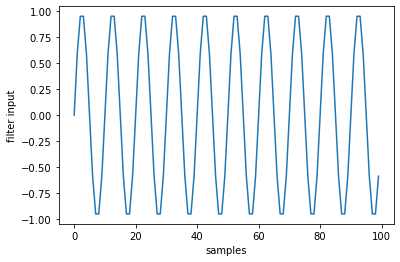

In [38]:
plt.plot(signal_x[0:100])
plt.xlabel('samples')
plt.ylabel('filter input')
plt.show()

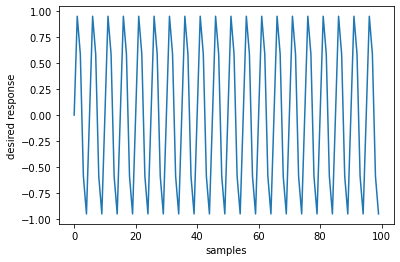

In [39]:
plt.plot(signal_y[0:100])
plt.xlabel('samples')
plt.ylabel('desired response')
plt.show()

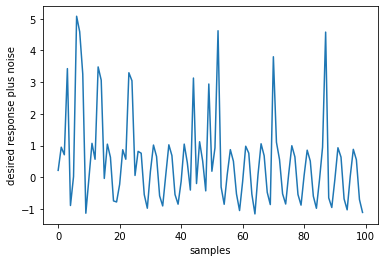

In [40]:
plt.plot(signal_ny[0:100])
plt.xlabel('samples')
plt.ylabel('desired response plus noise')
plt.show()

[  2.7391423   39.33267579  79.24730115 102.47115811  10.17930585
  -0.91828349  18.96858613 103.38852675 100.01704956  -4.547097  ]
MSE_Wiener: 0.5000000000000099


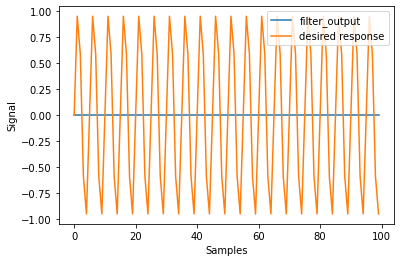

In [73]:
# Wiener Filter

wiener_filter_x = np.array([signal_x[filter_order-i:len(signal_x)-i] for i in range(filter_order)])
wiener_filter_y = signal_y[filter_order:len(signal_y)]

# Autocorrelation
R = np.zeros((filter_order, filter_order))
for i in range (R.shape[0]):
    for j in range (R.shape[1]):
        R[i, j] = np.dot(wiener_filter_x[i], wiener_filter_x[j])

P = np.zeros((filter_order))
for i in range (P.shape[0]):
    P[i] = np.dot(wiener_filter_x[i], wiener_filter_y)

w_opt = np.matmul(np.linalg.inv(R), P)
print(w_opt)

filter_output = []
for i in range (wiener_filter_x.shape[1]):
    filter_output.append(np.dot(wiener_filter_x[:, i], w_opt))
filter_output = np.array(filter_output)
print('MSE_Wiener:', np.sum((filter_output - wiener_filter_y) ** 2)/wiener_filter_x.shape[1])

# Plot the figure
l1 = plt.plot(filter_output[-100:])
l2 = plt.plot(wiener_filter_y[-100:])
plt.legend(['filter_output', 'desired response'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

In [49]:
wiener_filter_x[:, 2]

array([ 9.51056516e-01,  5.87785252e-01, -2.44929360e-16, -5.87785252e-01,
       -9.51056516e-01, -9.51056516e-01, -5.87785252e-01,  1.22464680e-16,
        5.87785252e-01,  9.51056516e-01])

The time of execution using LMS: 15.049513578414917


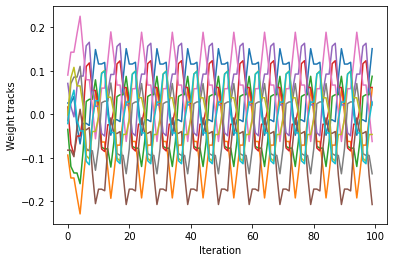

In [60]:
# LMS Algorithm

weight_filter = np.random.normal(0, 0.1, filter_order) # initialize weights 

mu = 0.1 # step size
MSE_test_num = 100

weight_LMS_store = []
error_LMS_store = []
LMS_trainMSE_store = []
LMS_testMSE_store = []

LMS_start = time.time()

for n in range(filter_order, len(signal_x)-MSE_test_num):
    e_n = signal_y[n] - np.dot(weight_filter, signal_x[n-filter_order:n][::-1])
    weight_filter = weight_filter + mu * signal_x[n-filter_order:n][::-1] * e_n
    weight_LMS_store.append(weight_filter)
    error_LMS_store.append(signal_y[n] - np.dot(weight_filter, signal_x[n-filter_order:n][::-1]))
    LMS_trainMSE_store.append(np.sum((np.array(error_LMS_store) ** 2))/len(error_LMS_store))
    MSE_store = []
    for i in range (n, n + MSE_test_num):
        MSE_store.append(signal_y[i] - np.dot(weight_filter, signal_x[i-filter_order:i][::-1]))
    MSE_store = np.array(MSE_store)
    LMS_testMSE_store.append(np.sum((MSE_store) ** 2)/len(MSE_store))

LMS_end = time.time()
print('The time of execution using LMS:', LMS_end - LMS_start)
    
# weight tracks
plt.plot(np.arange(len(weight_LMS_store[0:100])), weight_LMS_store[0:100])
plt.xlabel('Iteration')
plt.ylabel('Weight tracks')
plt.show()

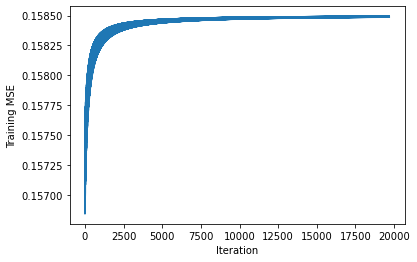

In [61]:
# training MSE
plt.plot(np.arange(len(LMS_trainMSE_store[200:])), LMS_trainMSE_store[200:])
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.show()

MSE_LMS: 0.15849067828139096


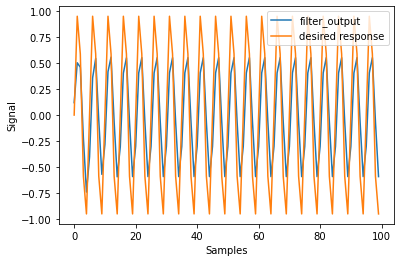

In [74]:
# Fitting curve
filter_output_LMS = []
for i in range (filter_order, len(signal_x)-MSE_test_num):
    filter_output_LMS.append(np.dot(weight_LMS_store[i-filter_order], signal_x[i-filter_order:i][::-1]))
filter_output_LMS = np.array(filter_output_LMS)
print('MSE_LMS:', np.sum((filter_output_LMS - signal_y[filter_order:len(signal_x)-MSE_test_num]) ** 2)/len(filter_output_LMS))

# Plot the figure
l1 = plt.plot(filter_output_LMS[0:100])
l2 = plt.plot(signal_y[filter_order:100+filter_order])
plt.legend(['filter_output', 'desired response'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

The time of execution using KLMS: 104.59347581863403


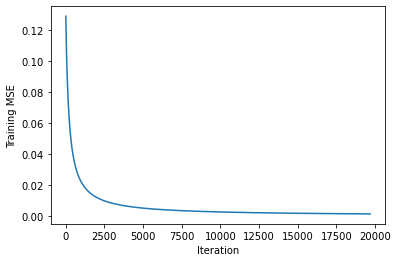

In [11]:
# KLMS Algorithm

mu = 0.1 # step size
MSE_test_num = 100
h = 1 / (2 * 0.4 ** 2) # parameter of Gaussian kernel

# data process with filter order
filter_x = np.array([signal_x[i-filter_order:i][::-1] for i in range(filter_order, len(signal_x))])
filter_y = signal_y[filter_order:len(signal_x)]

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))

# define KLMS
KLMS_error_store = []
KLMS_center_list = []
KLMS_alpha_list = []
KLMS_network_size = []
KLMS_trainMSE_store = []

KLMS_start = time.time()

for i in range (len(filter_x) - MSE_test_num): #len(filter_x) - MSE_test_num
    if i == 0:
        filter_output = 0
    else:
        filter_output = np.array(KLMS_alpha_list) @ kernel(filter_x[i], np.array(KLMS_center_list), h)
    KLMS_error_store.append(filter_y[i] - filter_output)
    KLMS_alpha_list.append(mu * (filter_y[i] - filter_output))
    KLMS_center_list.append(filter_x[i])
    KLMS_network_size.append(len(KLMS_center_list))
    KLMS_trainMSE_store.append(np.sum((np.array(KLMS_error_store) ** 2))/len(KLMS_error_store))

KLMS_end = time.time()
print('The time of execution using KLMS:', KLMS_end - KLMS_start)
    
# training MSE
plt.plot(np.arange(len(KLMS_trainMSE_store[200:])), KLMS_trainMSE_store[200:])
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.show()

In [30]:
# Calculate training and testing MSE
print("training MSE of LMS Algorithm:", LMS_trainMSE_store[-1])
print("training MSE of KLMS Algorithm:", KLMS_trainMSE_store[-1])

print("testing MSE of LMS Algorithm:", LMS_testMSE_store[-1])
print("testing MSE of KLMS Algorithm:", KLMS_testMSE_store[-1])

training MSE of LMS Algorithm: 0.6339742250172637
training MSE of KLMS Algorithm: 0.001320977316672272
testing MSE of LMS Algorithm: 0.6974959332676437
testing MSE of KLMS Algorithm: 8.414303771949276e-25


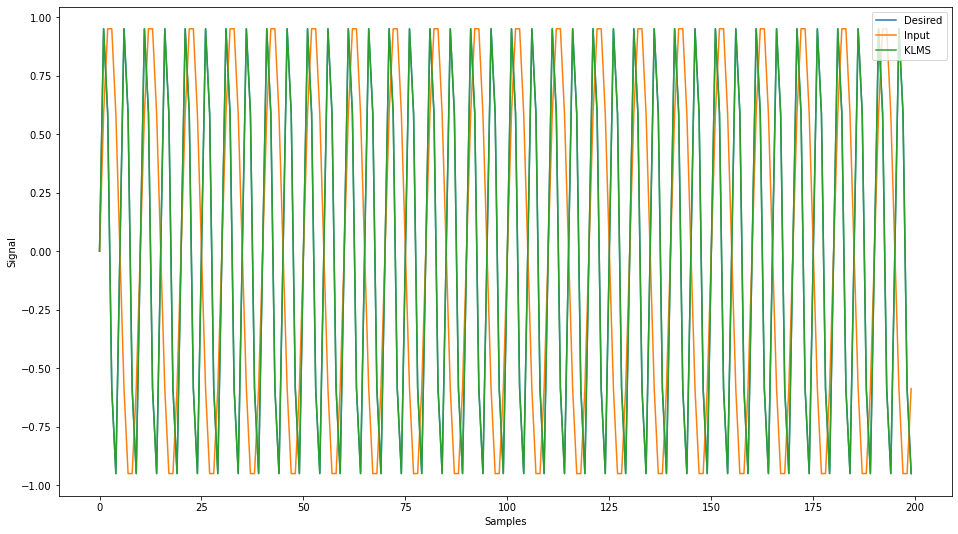

In [12]:
filter_xx = np.array([signal_x[i-filter_order:i][::-1] for i in range(filter_order, len(signal_x))])
filter_yy = signal_y[filter_order:len(signal_x)]

KLMS_filter_yy = []

for kk in range (len(filter_yy)):
    KLMS_filter_yy.append(np.array(KLMS_alpha_list) @ kernel(filter_xx[kk], np.array(KLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_yy[0:200])), filter_yy[0:200])
l2 = plt.plot(np.arange(len(filter_xx[0:200,filter_order-1])), filter_xx[0:200,filter_order-1])
l3 = plt.plot(np.arange(len(filter_yy[0:200])), KLMS_filter_yy[0:200])
plt.legend(['Desired', 'Input', 'KLMS'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

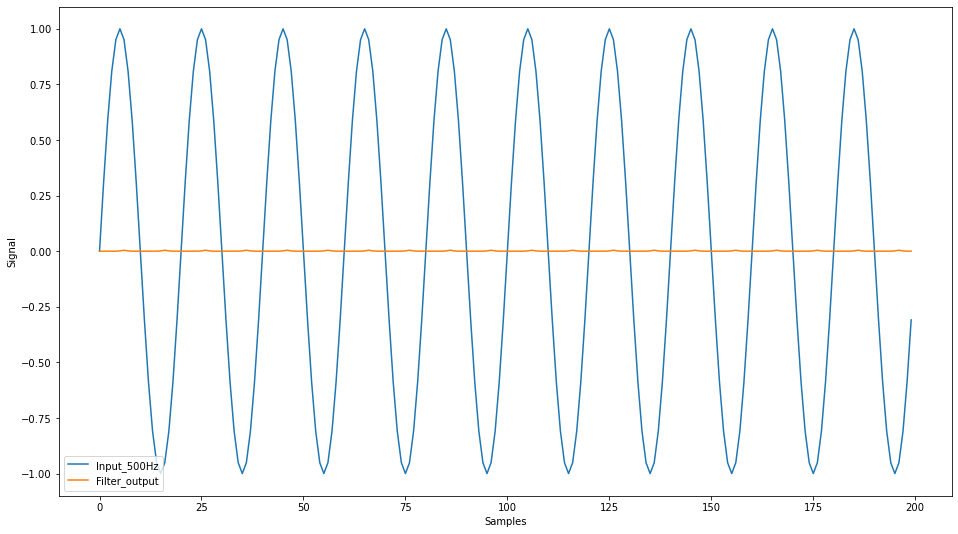

In [77]:
# Test the generalization of the trained model

# Generate test signal 1

freq_test = 500
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

KLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    KLMS_filter_yy_test.append(np.array(KLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(KLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(KLMS_filter_yy_test[0:200])), KLMS_filter_yy_test[0:200])
plt.legend(['Input_500Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

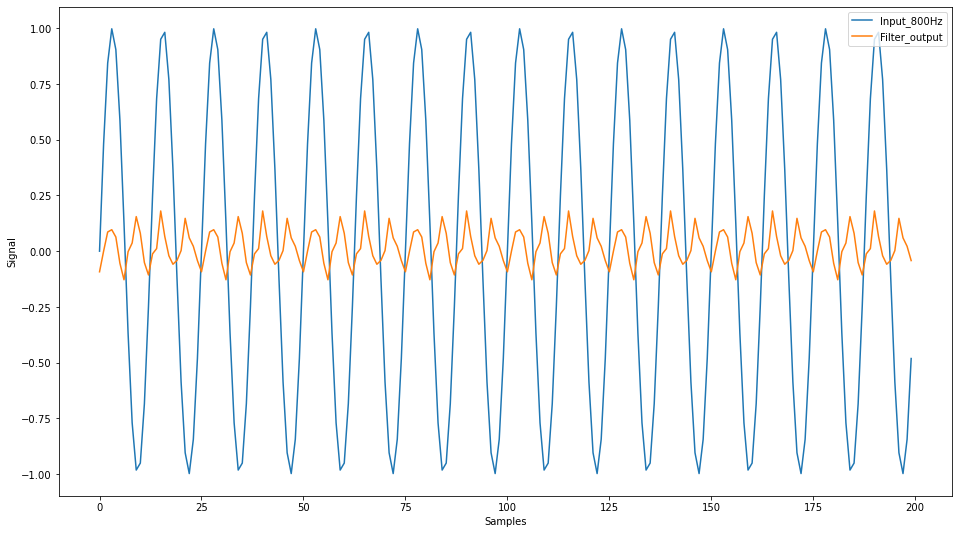

In [13]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 800
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

KLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    KLMS_filter_yy_test.append(np.array(KLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(KLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(KLMS_filter_yy_test[0:200])), KLMS_filter_yy_test[0:200])
plt.legend(['Input_800Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

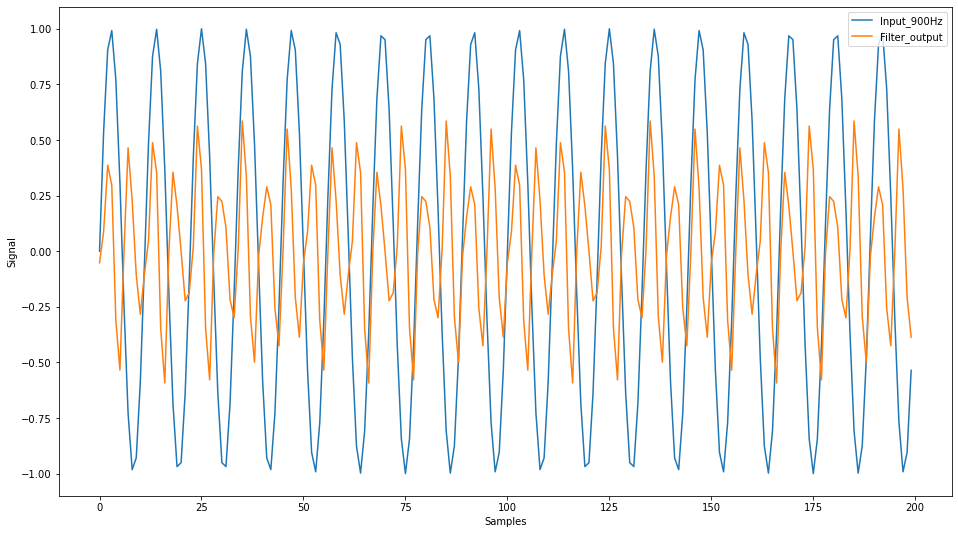

In [89]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 900
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

KLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    KLMS_filter_yy_test.append(np.array(KLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(KLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(KLMS_filter_yy_test[0:200])), KLMS_filter_yy_test[0:200])
plt.legend(['Input_900Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

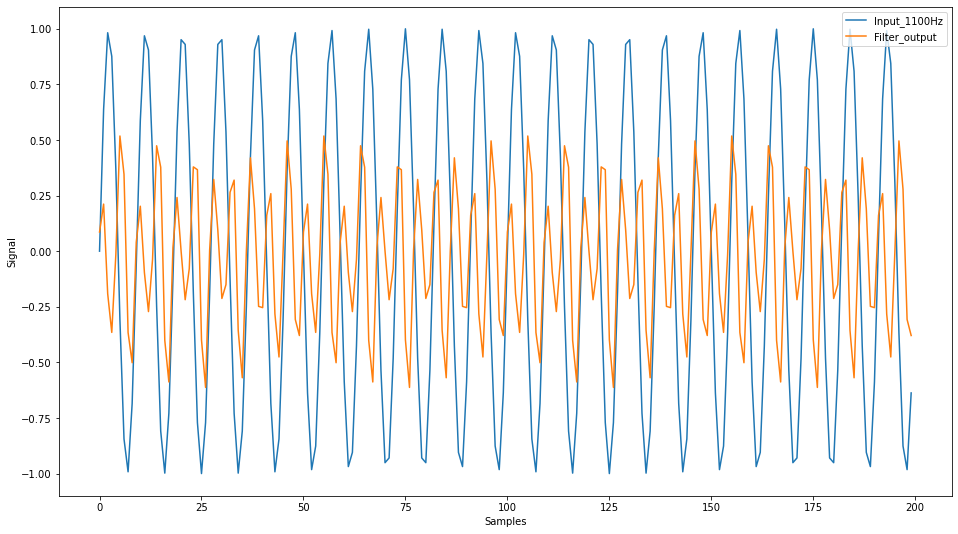

In [14]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 1100
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

KLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    KLMS_filter_yy_test.append(np.array(KLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(KLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(KLMS_filter_yy_test[0:200])), KLMS_filter_yy_test[0:200])
plt.legend(['Input_1100Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

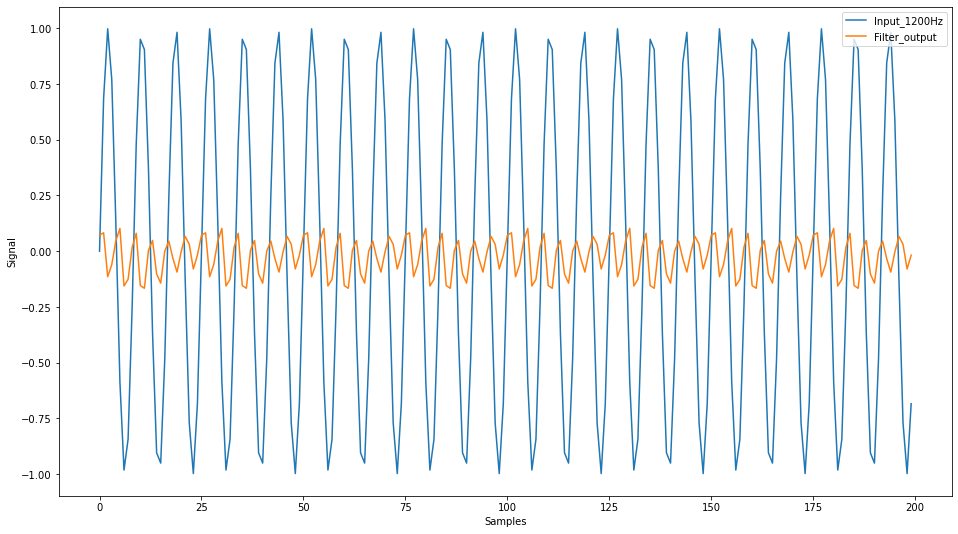

In [91]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 1200
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

KLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    KLMS_filter_yy_test.append(np.array(KLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(KLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(KLMS_filter_yy_test[0:200])), KLMS_filter_yy_test[0:200])
plt.legend(['Input_1200Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

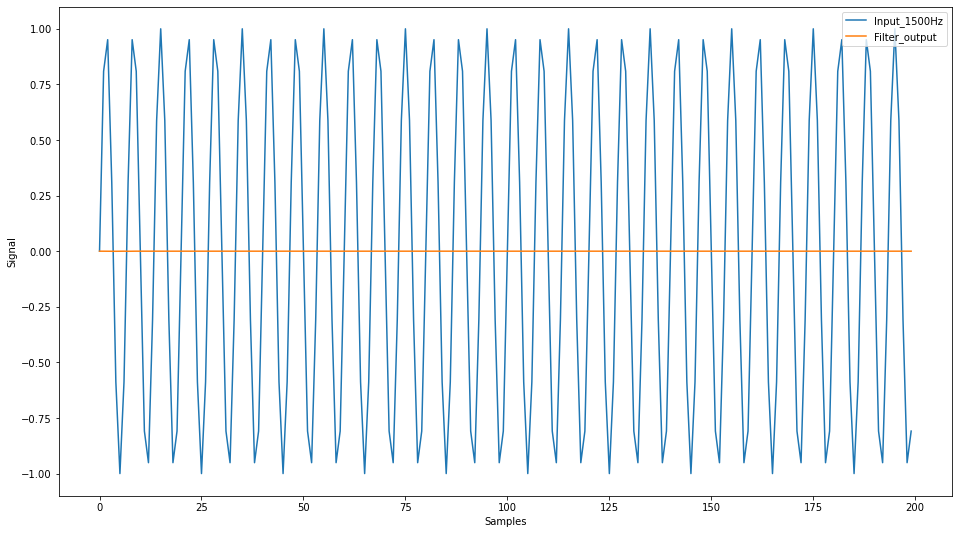

In [84]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 1500
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

KLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    KLMS_filter_yy_test.append(np.array(KLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(KLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(KLMS_filter_yy_test[0:200])), KLMS_filter_yy_test[0:200])
plt.legend(['Input_1500Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

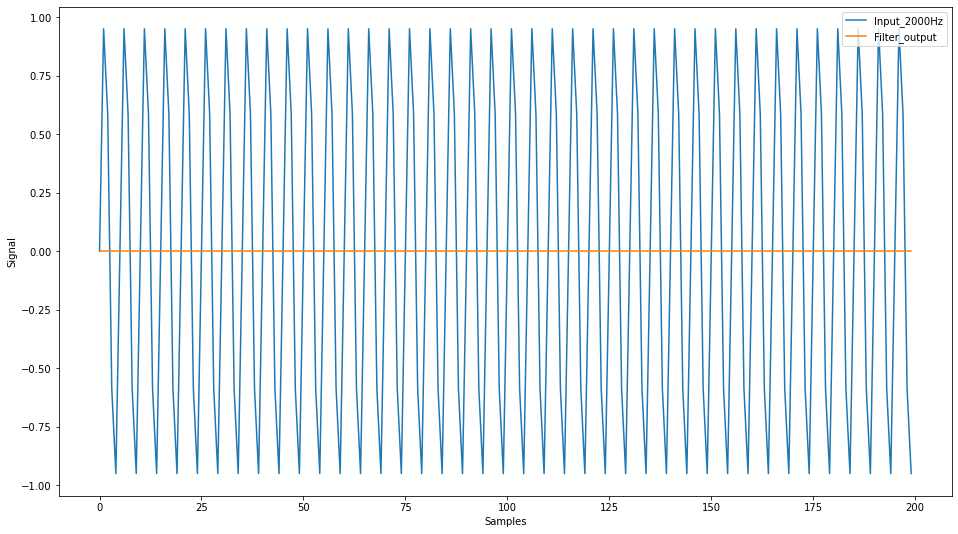

In [85]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 2000
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

KLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    KLMS_filter_yy_test.append(np.array(KLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(KLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(KLMS_filter_yy_test[0:200])), KLMS_filter_yy_test[0:200])
plt.legend(['Input_2000Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

The time of execution using KLMS: 107.24176406860352


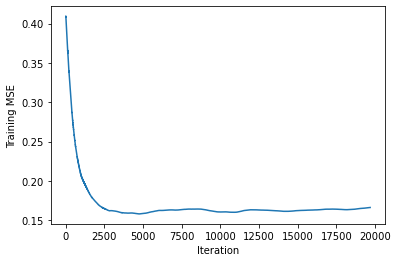

In [16]:
# noisy desired response

# KLMS Algorithm

mu = 0.01 # step size
MSE_test_num = 100
h = 1 / (2 * 0.4 ** 2) # parameter of Gaussian kernel

# data process with filter order
filter_x = np.array([signal_x[i-filter_order:i][::-1] for i in range(filter_order, len(signal_x))])
filter_ny = signal_ny[filter_order:len(signal_x)]

# define kernel
def kernel(x1, x2, h):
    return np.exp(-h * np.sum((x1 - x2) ** 2, axis = 1))

# define KLMS
nKLMS_error_store = []
nKLMS_center_list = []
nKLMS_alpha_list = []
nKLMS_network_size = []
nKLMS_trainMSE_store = []

nKLMS_start = time.time()

for i in range (len(filter_x) - MSE_test_num): #len(filter_x) - MSE_test_num
    if i == 0:
        filter_output = 0
    else:
        filter_output = np.array(nKLMS_alpha_list) @ kernel(filter_x[i], np.array(nKLMS_center_list), h)
    nKLMS_error_store.append(filter_y[i] - filter_output)
    nKLMS_alpha_list.append(mu * (filter_ny[i] - filter_output))
    nKLMS_center_list.append(filter_x[i])
    nKLMS_network_size.append(len(nKLMS_center_list))
    nKLMS_trainMSE_store.append(np.sum((np.array(nKLMS_error_store) ** 2))/len(nKLMS_error_store))
    

nKLMS_end = time.time()
print('The time of execution using KLMS:', nKLMS_end - nKLMS_start)
    
# training MSE
plt.plot(np.arange(len(nKLMS_trainMSE_store[200:])), nKLMS_trainMSE_store[200:])
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.show()

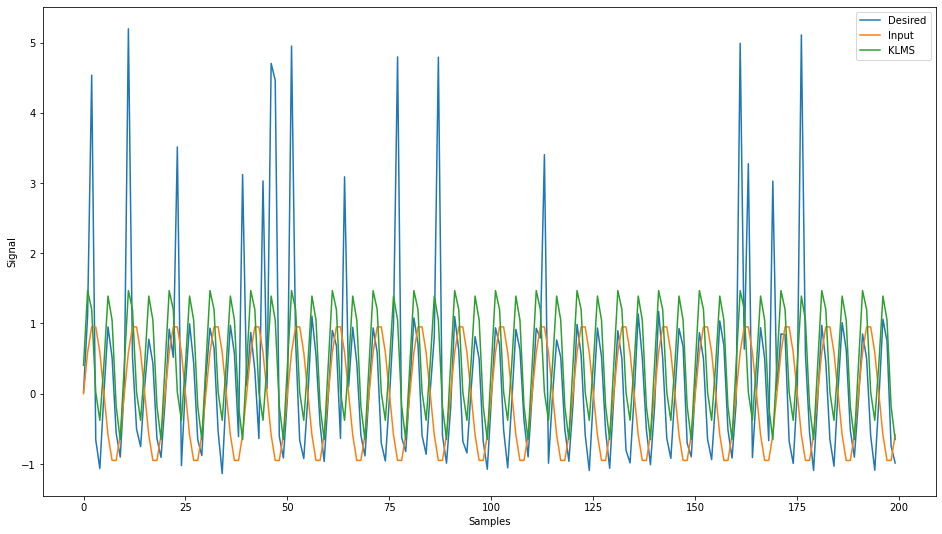

In [17]:
filter_xx = np.array([signal_x[i-filter_order:i][::-1] for i in range(filter_order, len(signal_x))])
filter_nyy = signal_ny[filter_order:len(signal_x)]

nKLMS_filter_yy = []

for kk in range (len(filter_nyy)):
    nKLMS_filter_yy.append(np.array(nKLMS_alpha_list) @ kernel(filter_xx[kk], np.array(nKLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_nyy[0:200])), filter_nyy[0:200])
l2 = plt.plot(np.arange(len(filter_xx[0:200,filter_order-1])), filter_xx[0:200,filter_order-1])
l3 = plt.plot(np.arange(len(filter_nyy[0:200])), nKLMS_filter_yy[0:200])
plt.legend(['Desired', 'Input', 'KLMS'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

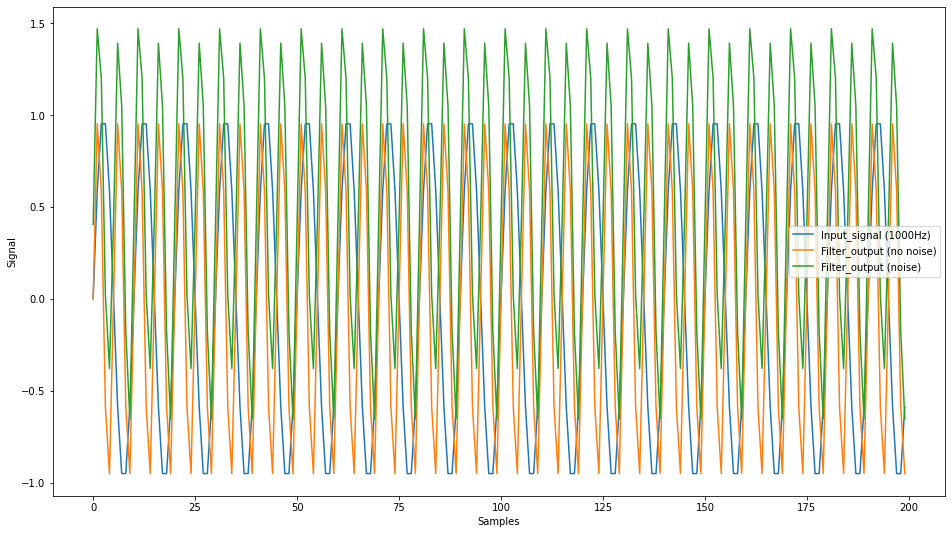

In [19]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 1000
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

nKLMS_filter_yy_test = []
NKLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    nKLMS_filter_yy_test.append(np.array(nKLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(nKLMS_center_list), h))
    NKLMS_filter_yy_test.append(np.array(KLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(KLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(NKLMS_filter_yy_test[0:200])), NKLMS_filter_yy_test[0:200])
l3 = plt.plot(np.arange(len(nKLMS_filter_yy_test[0:200])), nKLMS_filter_yy_test[0:200])
plt.legend(['Input_signal (1000Hz)', 'Filter_output (no noise)', 'Filter_output (noise)'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

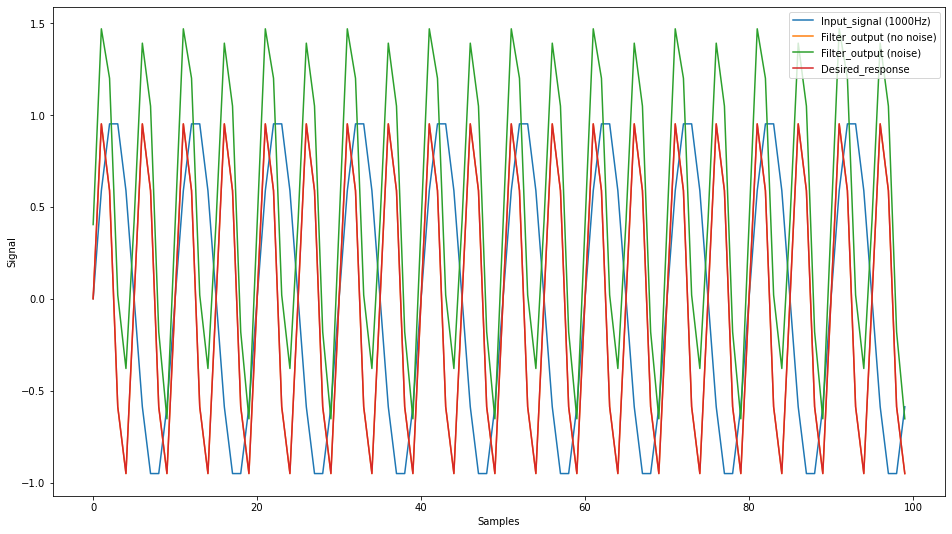

In [20]:
filter_yy = signal_y[filter_order:len(signal_x)]

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:100,filter_order-1])), filter_xx_test[0:100,filter_order-1])
l2 = plt.plot(np.arange(len(NKLMS_filter_yy_test[0:100])), NKLMS_filter_yy_test[0:100])
l3 = plt.plot(np.arange(len(nKLMS_filter_yy_test[0:100])), nKLMS_filter_yy_test[0:100])
l4 = plt.plot(np.arange(len(filter_yy[0:100])), filter_yy[0:100])
plt.legend(['Input_signal (1000Hz)', 'Filter_output (no noise)', 'Filter_output (noise)', 'Desired_response'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

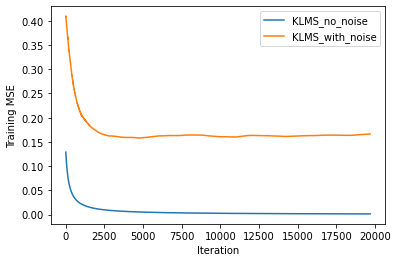

In [21]:
# training MSE
l1 = plt.plot(np.arange(len(KLMS_trainMSE_store[200:])), KLMS_trainMSE_store[200:])
l2 = plt.plot(np.arange(len(nKLMS_trainMSE_store[200:])), nKLMS_trainMSE_store[200:])
plt.legend(['KLMS_no_noise', 'KLMS_with_noise'])
plt.xlabel('Iteration')
plt.ylabel('Training MSE')
plt.show()

In [103]:
# Calculate MSE
filter_yy = signal_y[filter_order:len(signal_x)]
print('MSE_LMS_no_noise:', np.sum((NKLMS_filter_yy_test - filter_yy) **2)/len(filter_yy))
print('MSE_LMS_noise:', np.sum((nKLMS_filter_yy_test - filter_yy) **2)/len(filter_yy))

MSE_LMS_no_noise: 8.173585366321423e-25
MSE_LMS_noise: 0.13477555760512636


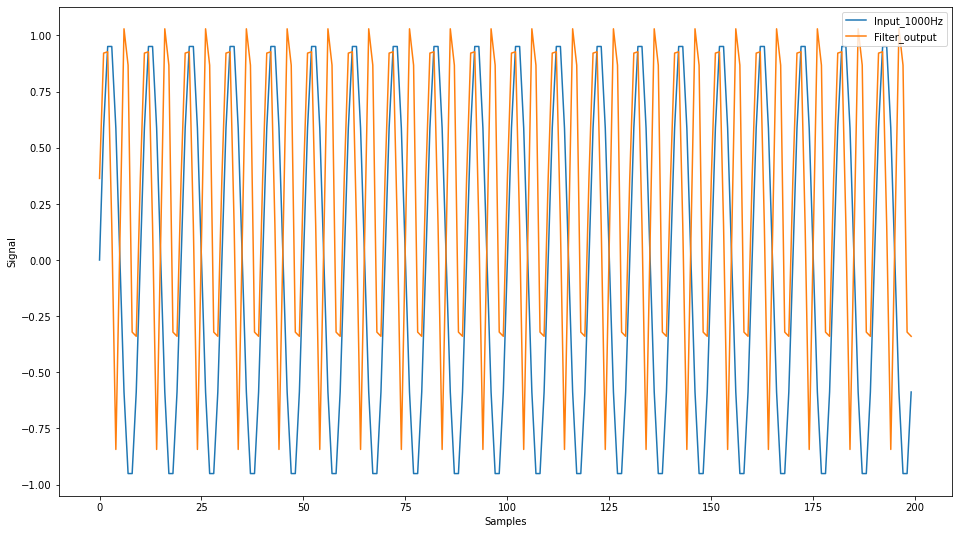

In [100]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 1000
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

nKLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    nKLMS_filter_yy_test.append(np.array(nKLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(nKLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(nKLMS_filter_yy_test[0:200])), nKLMS_filter_yy_test[0:200])
plt.legend(['Input_1000Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

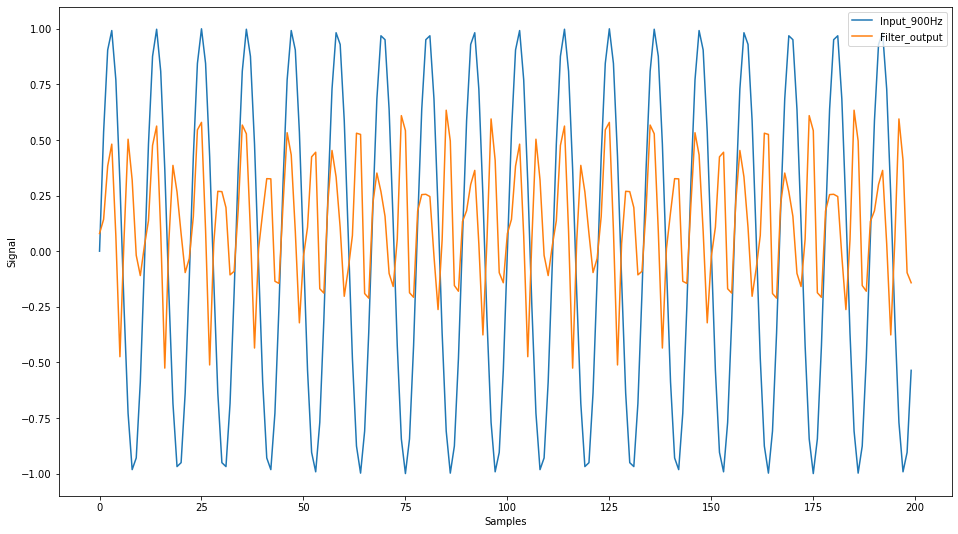

In [92]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 900
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

nKLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    nKLMS_filter_yy_test.append(np.array(nKLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(nKLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(nKLMS_filter_yy_test[0:200])), nKLMS_filter_yy_test[0:200])
plt.legend(['Input_900Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

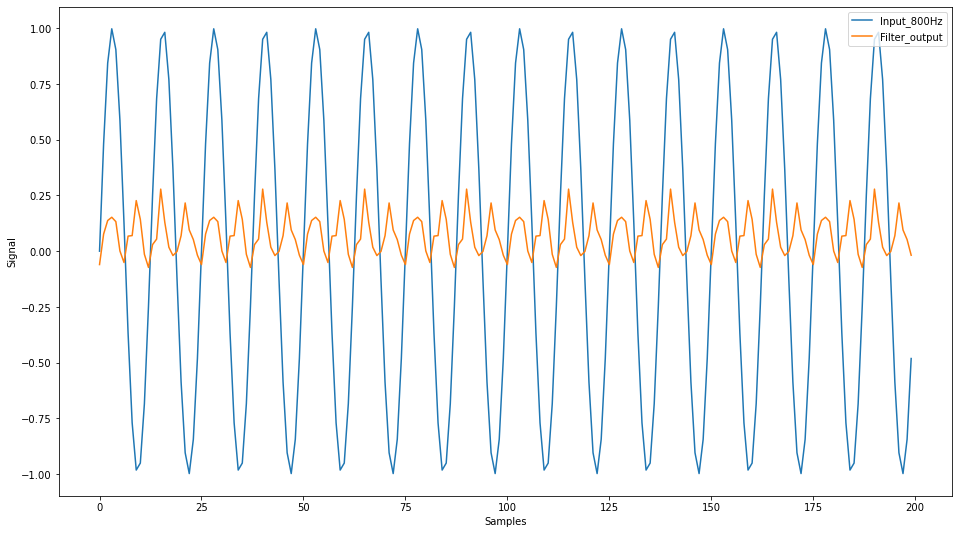

In [22]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 800
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

nKLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    nKLMS_filter_yy_test.append(np.array(nKLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(nKLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(nKLMS_filter_yy_test[0:200])), nKLMS_filter_yy_test[0:200])
plt.legend(['Input_800Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

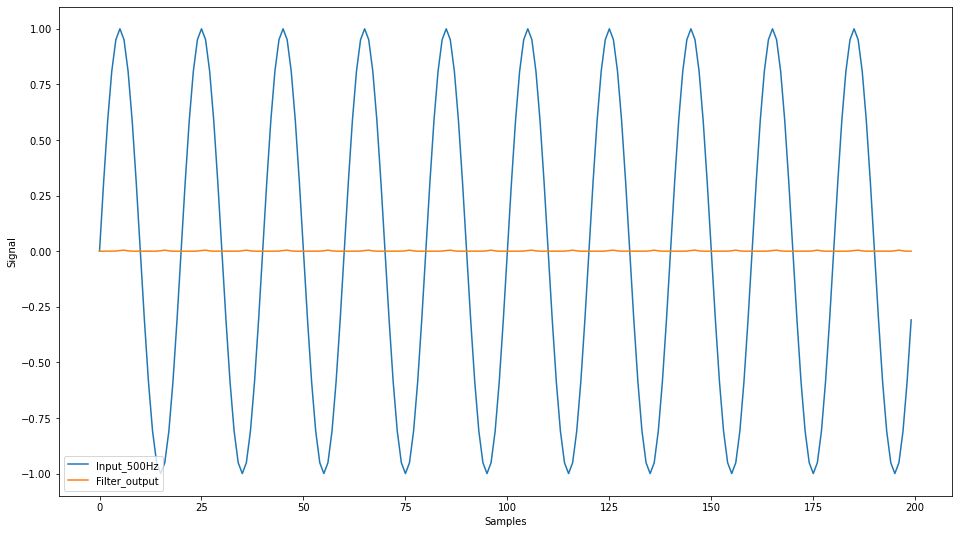

In [95]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 500
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

nKLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    nKLMS_filter_yy_test.append(np.array(nKLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(nKLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(nKLMS_filter_yy_test[0:200])), nKLMS_filter_yy_test[0:200])
plt.legend(['Input_500Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

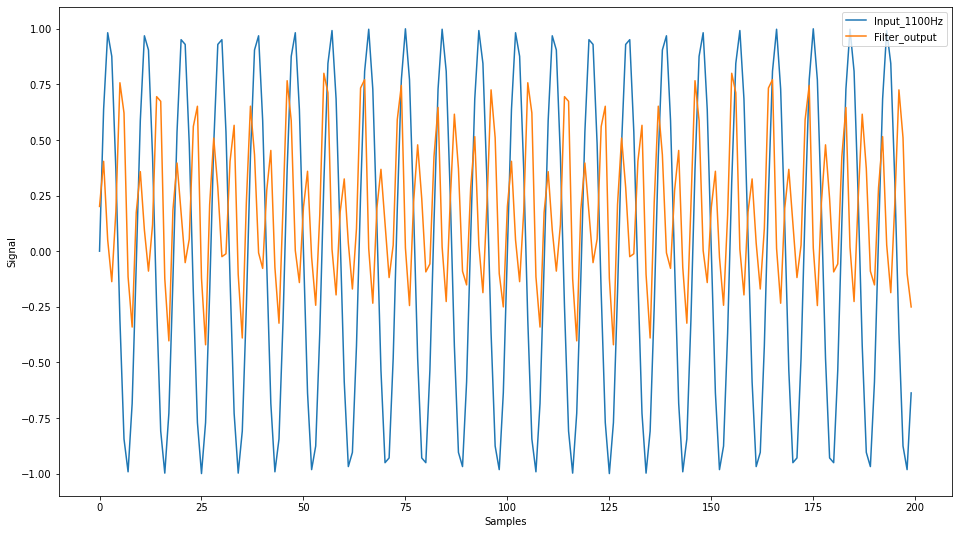

In [23]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 1100
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

nKLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    nKLMS_filter_yy_test.append(np.array(nKLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(nKLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(nKLMS_filter_yy_test[0:200])), nKLMS_filter_yy_test[0:200])
plt.legend(['Input_1100Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

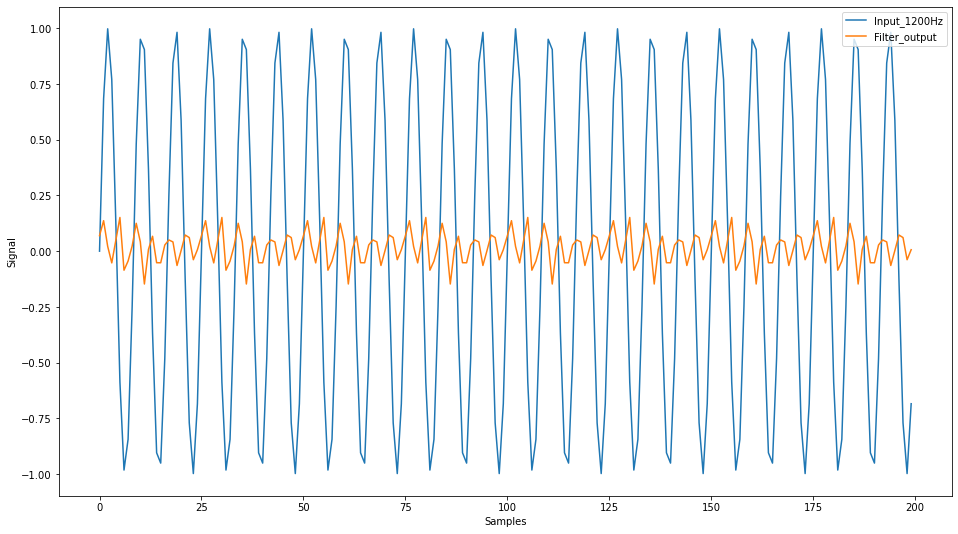

In [97]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 1200
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

nKLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    nKLMS_filter_yy_test.append(np.array(nKLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(nKLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(nKLMS_filter_yy_test[0:200])), nKLMS_filter_yy_test[0:200])
plt.legend(['Input_1200Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

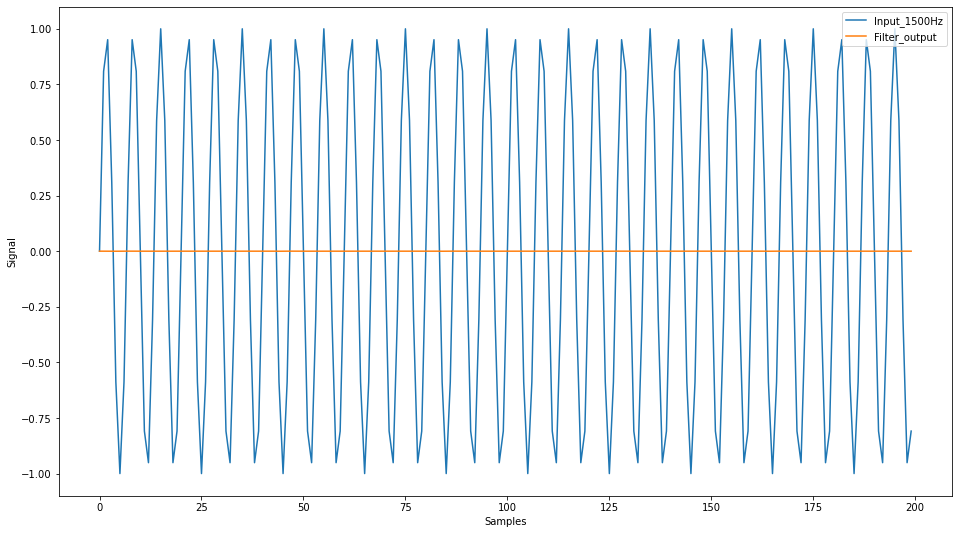

In [98]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 1500
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

nKLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    nKLMS_filter_yy_test.append(np.array(nKLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(nKLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(nKLMS_filter_yy_test[0:200])), nKLMS_filter_yy_test[0:200])
plt.legend(['Input_1500Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()

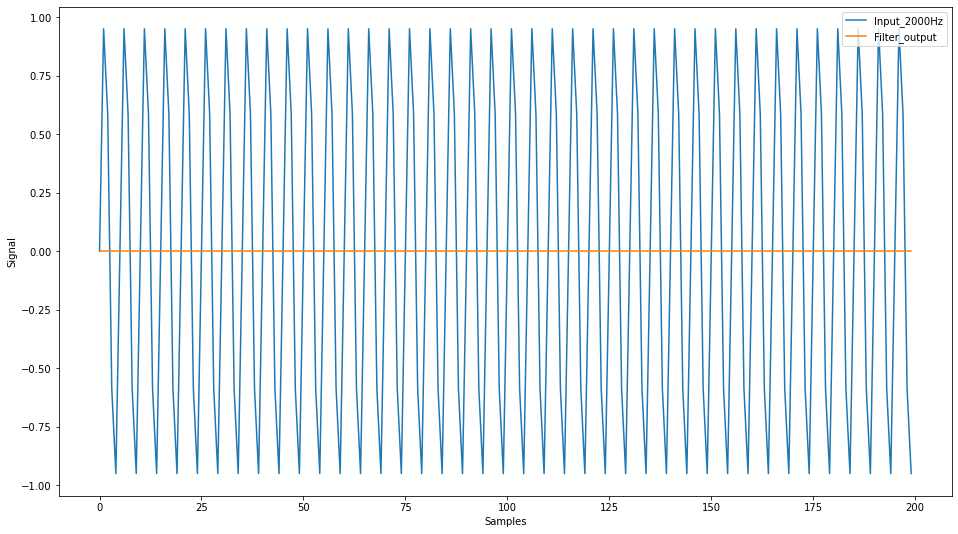

In [99]:
# Test the generalization of the trained model

# Generate test signal 2

freq_test = 2000
input_x_test = np.sin(2 * math.pi * freq_test * t)

filter_xx_test = np.array([input_x_test[i-filter_order:i][::-1] for i in range(filter_order, len(input_x_test))])

nKLMS_filter_yy_test = []

for kk in range (filter_xx_test.shape[0]):
    nKLMS_filter_yy_test.append(np.array(nKLMS_alpha_list) @ kernel(filter_xx_test[kk], np.array(nKLMS_center_list), h))

fig = plt.figure(figsize = (16,9))
l1 = plt.plot(np.arange(len(filter_xx_test[0:200,filter_order-1])), filter_xx_test[0:200,filter_order-1])
l2 = plt.plot(np.arange(len(nKLMS_filter_yy_test[0:200])), nKLMS_filter_yy_test[0:200])
plt.legend(['Input_2000Hz', 'Filter_output'])
plt.xlabel('Samples')
plt.ylabel('Signal')
plt.show()